In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [3]:
df.drop_duplicates()

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionDate,MissionNumber,PULOC,DropLoc,...,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,NonCriminal
0,Removal,M,Non-Criminal,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
1,Removal,M,Non-Criminal,No,1.0,38.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
2,Removal,M,Non-Criminal,No,1.0,20.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
3,Removal,M,Non-Criminal,No,1.0,29.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
4,Removal,M,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
5,Removal,M,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
6,Removal,M,Traffic Offense,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
7,Removal,M,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
8,Removal,M,Non-Criminal,No,1.0,23.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
9,Removal,M,Non-Criminal,No,1.0,19.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False


# Global variables

Here we calculate top-level data on the global scope of the ICE Air dataset.

In [4]:
pre_drop = len(df)
df = df.drop_duplicates()
post_drop = len(df)
assert pre_drop == post_drop

number_of_records = len(df)
print(f'Number of records: {number_of_records}')

unique_AlienMasterID = len(set(df['AlienMasterID']))
assert sum(df['AlienMasterID'].isnull()) == 0
print(f"Unique AlienMasterID values: {unique_AlienMasterID}")

Number of records: 1763020
Unique AlienMasterID values: 1733555


No missing values in ID fields. IDs repeat.

In [5]:
unique_MissionID = len(set(df['MissionID']))
assert sum(df['MissionID'].isnull()) == 0
print(f"Unique MissionID values: {unique_MissionID}")

unique_MissionNumber = len(set(df['MissionNumber']))
assert sum(df['MissionNumber'].isnull()) == 0
print(f"Unique MissionNumber values: {unique_MissionNumber}")

Unique MissionID values: 14973
Unique MissionNumber values: 14973


One to one relationship of MissionID to MissionNumber. These fields seem to be equivalent. Ordering does not affect calculations.

In [6]:
assert sum(df.groupby(['MissionID', 'MissionNumber'])['MissionNumber'].nunique() > 1) == 0
assert sum(df.groupby(['MissionNumber', 'MissionID'])['MissionID'].nunique() > 1) == 0

missions = df.groupby(['MissionDate', 'MissionID', 'MissionNumber', 'PULOC', 'DropLoc'])
missions_alt = df.groupby(['MissionDate', 'MissionNumber', 'MissionID',  'PULOC', 'DropLoc'])
assert len(missions) == len(missions_alt)
del missions_alt
mission_segments = len(missions)
print(f"{mission_segments} unique flight segments, grouped by mission and date.")

41247 unique flight segments, grouped by mission and date.


The following is a glimpse of flight segments from the first day in the dataset, showing how flight segments are grouped. We can only assume that a unique combination of `PULOC` and `DropLoc` on a given mission represents a unique flight.

In [7]:
missions['AlienMasterID'].nunique().head(10)

MissionDate  MissionID  MissionNumber  PULOC  DropLoc
2010-10-01   105        110005         KMDT   KAEX       122
             106        110006         KHRL   MGGT        67
                                       KSAT   MGGT        37
             107        110007         KAEX   MHLM        97
             108        110008         KMCI   KAEX        10
                                              KHRL        35
                                       KORD   KAEX        25
                                              KHRL        63
             131        110002         KBFL   KIWA         3
                                              KSAN        21
Name: AlienMasterID, dtype: int64

In [8]:
earliest_record = df['MissionDate'].min()
print(f'Earliest record: {earliest_record}')
latest_record = df['MissionDate'].max()
print(f'Earliest record: {latest_record}')

Earliest record: 2010-10-01 00:00:00
Earliest record: 2018-12-05 00:00:00


In [9]:
number_of_pickup_airports = len(set(df['PULOC'].dropna()))
number_of_dropoff_airports = len(set(df['DropLoc'].dropna()))
print(f'Number of pickup airports: {number_of_pickup_airports}')
print(f'Number of dropoff airports: {number_of_dropoff_airports}')

Number of pickup airports: 83
Number of dropoff airports: 206


The number of unique pickup and dropoff airports represented in the dataset per year can be interpreted as a metric for the expansion of the ICE Air network over time.

In [10]:
droplocs_per_fy = df.resample('AS-OCT', on='MissionDate')['DropLoc']
pulocs_per_fy = df.resample('AS-OCT', on='MissionDate')['PULOC']

In [11]:
unique_droplocs = droplocs_per_fy.nunique()
unique_pulocs = pulocs_per_fy.nunique()
expansion = pd.DataFrame({'Unique Pickup Airports': unique_pulocs, 'Unique Dropoff Airports': unique_droplocs})
expansion.index = expansion.index.year + 1
expansion.index.name = 'FY'
# expansion.to_csv('../output/iceair-expansion.csv')
expansion

,Unique Pickup Airports,Unique Dropoff Airports
FY,,
2011,41,69
2012,45,78
2013,46,48
2014,41,62
2015,36,60
2016,39,87
2017,40,85
2018,41,108
2019,31,52


Or we could look at cumulative growth of network:

In [12]:
droplocs = set()
droploc_growth = []
droploc_count = droplocs_per_fy.value_counts().unstack()
for year in droploc_count.index.year:
    year_locs = droploc_count[f'{year}'].dropna(axis=1).columns.tolist()
    droplocs.update(year_locs)
    droploc_growth.append(len(droplocs))

In [13]:
pulocs = set()
puloc_growth = []
puloc_count = pulocs_per_fy.value_counts().unstack()
for year in puloc_count.index.year:
    year_locs = puloc_count[f'{year}'].dropna(axis=1).columns.tolist()
    pulocs.update(year_locs)
    puloc_growth.append(len(pulocs))

In [14]:
growth = pd.DataFrame({'Growth of Pickup Airports': puloc_growth, 'Growth of Dropoff Airports': droploc_growth})
growth.index = droploc_count.index.year + 1
growth.index.name = 'FY'
growth

,Growth of Pickup Airports,Growth of Dropoff Airports
FY,,
2011,41,69
2012,52,100
2013,61,105
2014,68,120
2015,70,135
2016,75,161
2017,79,183
2018,83,205
2019,83,206


# Most common pickup, dropoff airports

By unique `AlienMasterID` values:

In [15]:
df.drop_duplicates('AlienMasterID')['air_AirportName'].value_counts().head(10)

Alexandria International Airport                        239903
Brownsville South Padre Island International Airport    204895
Phoenix-Mesa-Gateway Airport                            196139
El Paso International Airport                           136127
Valley International Airport                            125101
San Antonio International Airport                       107434
Columbus Metropolitan Airport                            80797
Harrisburg International Airport                         76348
Laredo International Airport                             56409
Miami International Airport                              55588
Name: air_AirportName, dtype: int64

In [16]:
df.drop_duplicates('AlienMasterID')['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                       327010
Ramon Villeda Morales International Airport             202955
Alexandria International Airport                        169316
El Salvador International Airport                       157773
Valley International Airport                            148700
Phoenix-Mesa-Gateway Airport                             93892
El Paso International Airport                            87186
Licenciado Benito Juarez International Airport           85584
Brownsville South Padre Island International Airport     66444
San Diego International Airport                          62943
Name: air2_AirportName, dtype: int64

By unique `MissionID` values, an estimate of total number of flights (dropping duplicate date and mission values doesn't change calculation):

In [17]:
count1 = df.drop_duplicates('MissionID')['air_AirportName'].value_counts()
count2 = df.drop_duplicates(['MissionDate', 'MissionID'])['air_AirportName'].value_counts()
assert sum(count1 == count2) == len(count1)
del count1, count2
df.drop_duplicates('MissionID')['air_AirportName'].value_counts().head(10)

Phoenix-Mesa-Gateway Airport                            3183
Alexandria International Airport                        3040
Brownsville South Padre Island International Airport    1550
San Antonio International Airport                       1475
Miami International Airport                             1051
Valley International Airport                             901
El Paso International Airport                            750
Columbus Metropolitan Airport                            369
Laredo International Airport                             279
Harrisburg International Airport                         259
Name: air_AirportName, dtype: int64

In [18]:
count1 = df.drop_duplicates('MissionID')['air2_AirportName'].value_counts()
count2 = df.drop_duplicates(['MissionDate', 'MissionID'])['air2_AirportName'].value_counts()
assert sum(count1 == count2) == len(count1)
del count1, count2
df.drop_duplicates('MissionID')['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                 2924
Ramon Villeda Morales International Airport       1734
El Salvador International Airport                 1420
Alexandria International Airport                   943
Valley International Airport                       928
Licenciado Benito Juarez International Airport     642
San Diego International Airport                    623
El Paso International Airport                      523
Newark Liberty International Airport               403
Harrisburg International Airport                   391
Name: air2_AirportName, dtype: int64

In [19]:
pickup_countries = set(df['air_Country'].dropna())
print(f'Number of pickup countries: {len(pickup_countries)}')
dropoff_countries = set(df['air2_Country'].dropna())
print(f'Number of dropoff countries: {len(dropoff_countries)}')
all_countries = pickup_countries.union(dropoff_countries)
print(f'Total countries in ICE Air network (including US): {len(dropoff_countries)}')

Number of pickup countries: 10
Number of dropoff countries: 119
Total countries in ICE Air network (including US): 119


Top nationalities:

In [20]:
df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(15)

MEXICO                568039
GUATEMALA             421411
HONDURAS              304685
EL SALVADOR           256834
DOMINICAN REPUBLIC     31704
ECUADOR                25688
HAITI                  23308
NICARAGUA              18679
COLOMBIA               14520
JAMAICA                12800
INDIA                   8952
CHINA                   4459
CUBA                    3658
BANGLADESH              2790
SOMALIA                 2659
Name: CountryOfCitizenship, dtype: int64

In [21]:
df['Status'].str.upper().value_counts().head(20)

16                324026
REMOVAL           295613
8F                239278
8C                169499
8G                129512
RM                 98776
ER                 87709
VR                 63147
3                  37389
REINST             37125
11                 29086
TRANSFER - F/O     19869
REINSTATE          18431
NTA-TFRD           15633
8A                 13061
XFO                12290
ER-NEW             10141
TRANSFER - NTA      9967
8B                  7686
8E                  6359
Name: Status, dtype: int64

# Removal versus transfer rates

We might be interested in whether some groups are disproportionately transferred prior to removal. However, these values will be highly skewed because some groups have very few total removals.

In [22]:
removal_count = df.loc[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts()
transfer_count =  df.loc[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts()
transfer_rate = (transfer_count / removal_count).sort_values(ascending = False)
valid_comparisons = transfer_rate[transfer_rate != np.inf]

In [23]:
country = "GUATEMALA"

In [24]:
print(f'{country}: {round(valid_comparisons[country], 3)} transfers per removal ({transfer_count[country]}/{removal_count[country]})')

GUATEMALA: 0.29 transfers per removal (94628/326783)


# Finding repeat `AlienMasterID` values

Unfortunately, `AlienMasterID` values only allow us to track at maximum 2 flight segments for a given ID.

In [25]:
count = df.groupby(['AlienMasterID']).size().reset_index(name='count')
count.set_index('AlienMasterID', inplace=True)
df.set_index('AlienMasterID', inplace=True)
df = df.join(count, how='left')
print(f"Max AlienMasterID repeats: {df['count'].max()}")
more_than_one = df['count'] > 1
multiple_alienID = df[more_than_one]
df.reset_index(inplace=True)

# multiple_alienID.to_csv('../output/multiple_alienID.csv.gz', compression='gzip', sep='|')

Max AlienMasterID repeats: 2


# Most common, most passenger flight paths

We can rank flight paths by number of missions or unique passengers, perhaps for calculating costs of a common flight path.

In [26]:
most_common_flight_paths = df.groupby(['PULOC','DropLoc'])['MissionID'].nunique()
most_common_flight_path = most_common_flight_paths.idxmax()
most_common_flight_path_count =  most_common_flight_paths[most_common_flight_path]
most_passenger_flight_paths = df.groupby(['PULOC','DropLoc'])['AlienMasterID'].nunique()
most_passenger_flight_path = most_passenger_flight_paths.idxmax()
most_passenger_flight_path_count = most_passenger_flight_paths[most_passenger_flight_path]

In [27]:
print(f'Most frequent flight path: {most_common_flight_path}, {most_common_flight_path_count} missions')
print(f'Flight path with most passengers: {most_passenger_flight_path}, {most_passenger_flight_path_count} passengers')

Most frequent flight path: ('KOAK', 'KSAN'), 919 missions
Flight path with most passengers: ('KBRO', 'MGGT'), 91714 passengers


In [28]:
most_passenger_flight_path_trips = df.groupby(['PULOC','DropLoc'])['MissionNumber'].nunique()[most_passenger_flight_path]

In [29]:
cost_per_hour = 7785

In [30]:
kbro_to_mggt_duration_hrs = 5

In [31]:
most_passenger_flight_path_trips * kbro_to_mggt_duration_hrs * cost_per_hour

35694225

In [32]:
flight_path_rank = most_common_flight_paths.sort_values(ascending=False).reset_index()

In [33]:
flight_path_cross_table = most_common_flight_paths.unstack()
passenger_count_cross_table = most_passenger_flight_paths.unstack()

This is probably not a super interesting way to display this info but...

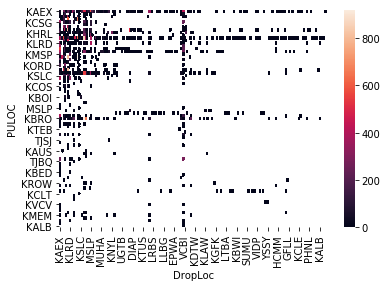

In [34]:
sns.heatmap(flight_path_cross_table)

# Trend charts

Charts for global trends in the ICE Air dataset, starting with simple plot of total removals and transfers per fiscal year (excluding FY19):

In [35]:
removal_df = df.loc[df['R-T'] == 'R']
transfer_df = df.loc[df['R-T'] == 'T']
removal_df.set_index('MissionDate', inplace=True)
transfer_df.set_index('MissionDate', inplace=True)

In [36]:
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total removals', inplace=True)
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total transfers', inplace=True)
annual_removal_flights = removal_df['MissionID'].resample('AS-OCT').nunique()
annual_transfer_flights = transfer_df['MissionID'].resample('AS-OCT').nunique()

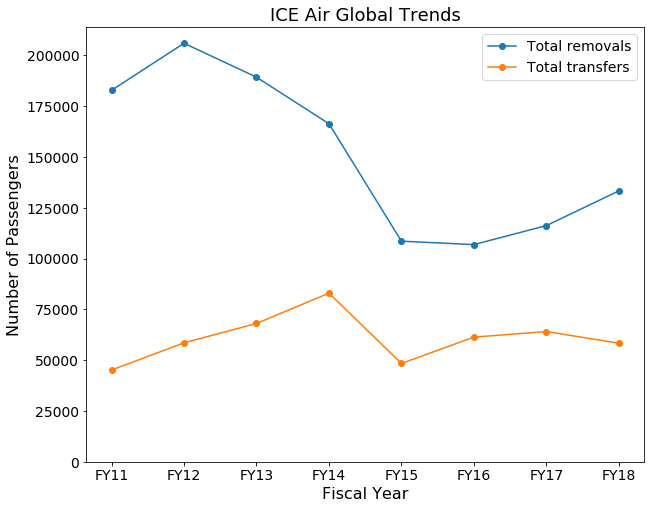

In [37]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(style='o-', legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'ICE Air Global Trends', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/ICE-Air-Global-Trends.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_removals['2010':'2017'], annual_transfers['2010':'2017']]);

To look at removals or other variables by `CountryOfCitizenship` per fiscal year (excluding FY19), we will want to select most common values and sum the rest, in order to create a clean chart. Method below selects top 5 nationalities per year, and sums the rest as "ALL OTHERS".

This is slightly counterintuitive, for example it creates illusion of no Dominican Republic removals in FY17. Maybe better solution would be to display for each year any nationality that is in top 5 for any given year. Alternatively, we could just plot top 5 values, or include several more over a certain threshold. Or we could plot all values for nationalities which are in the top 5 for any year.

In [38]:
df.set_index('MissionDate', inplace=True)

In [39]:
# Uncomment preferred groupby method to get table/figure of transfer nationalities, or all passengers
# Remember to change figure labels

# g = transfer_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
g = removal_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
# g = df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [40]:
# Selecting only years for which we have full data (FY2011 - FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [66]:
removal_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
removal_nationality_by_year.to_csv(f'../output/removal_nationality_by_year.csv')

In [67]:
removal_nationality_by_year

AlienMasterID                                            \
CountryOfCitizenship        BRAZIL CAMEROON CAPE VERDE CHINA COLOMBIA   CUBA   
FY                                                                             
2010-10-01                     1.0      2.0        4.0   6.0   1059.0   31.0   
2011-10-01                     NaN      1.0        NaN   4.0   1020.0   34.0   
2012-10-01                     NaN      NaN        NaN   NaN    943.0   16.0   
2013-10-01                     NaN      7.0        NaN   NaN    865.0    6.0   
2014-10-01                     NaN      9.0        NaN  16.0    847.0   16.0   
2015-10-01                     NaN      3.0        NaN   NaN    847.0   25.0   
2016-10-01                     NaN      5.0        NaN  47.0    795.0   53.0   
2017-10-01                     8.0     13.0        7.0  93.0    866.0  255.0   

                                                                     ...    \
CountryOfCitizenship DOMINICAN REPUBLIC ECUADOR EL SALVADOR  GHANA   ...     
FY                                                                   ...     
2010-10-01                       2343.0  1436.0     15817.0   17.0   ...     
2011-10-01                       2281.0  1595.0     18108.0   14.0   ...     
2012-10-01                       1849.0  1318.0     20178.0    NaN   ...     
2013-10-01                       1748.0  1377.0     26508.0    NaN   ...     
2014-10-01                       1552.0  1153.0     21378.0    NaN   ...     
2015-10-01                       1556.0   980.0     20089.0   17.0   ...     
2016-10-01                       1696.0   929.0     17970.0  172.0   ...     
2017-10-01                       1520.0  1036.0     14516.0  130.0   ...     

                                                                      \
CountryOfCitizenship SOUTH AFRICA ST. LUCIA BURKINA FASO SOUTH SUDAN   
FY                                                                     
2010-10-01                    NaN       NaN          NaN         NaN   
2011-10-01                    NaN       NaN          NaN         NaN   
2012-10-01                    NaN       NaN          NaN         NaN   
2013-10-01                    NaN       NaN          NaN         NaN   
2014-10-01                    NaN       NaN          NaN         NaN   
2015-10-01                    NaN       NaN          NaN         NaN   
2016-10-01                    NaN       NaN          NaN         NaN   
2017-10-01                    1.0       2.0          5.0        61.0   

                                                                         \
CountryOfCitizenship ANTIGUA & BARBUDA BURMA SAMOA UNITED ARAB EMIRATES   
FY                                                                        
2010-10-01                         NaN   NaN   NaN                  NaN   
2011-10-01                         NaN   NaN   NaN                  NaN   
2012-10-01                         NaN   NaN   NaN                  NaN   
2013-10-01                         NaN   NaN   NaN                  NaN   
2014-10-01                         NaN   NaN   NaN                  NaN   
2015-10-01                         NaN   NaN   NaN                  NaN   
2016-10-01                         NaN   NaN   NaN                  NaN   
2017-10-01                         3.0  33.0   6.0                  1.0   

                                          
CountryOfCitizenship PALESTINIAN NAMIBIA  
FY                                        
2010-10-01                   NaN     NaN  
2011-10-01                   NaN     NaN  
2012-10-01                   NaN     NaN  
2013-10-01                   NaN     NaN  
2014-10-01                   NaN     NaN  
2015-10-01                   NaN     NaN  
2016-10-01                   NaN     NaN  
2017-10-01                   4.0     2.0  

[8 rows x 132 columns]

In [41]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

In [42]:
# Note 0 values in this version of chart. Missing values are included in "ALL OTHERS" category.
top_5_data

CountryOfCitizenship,ALL OTHERS,DOMINICAN REPUBLIC,EL SALVADOR,GUATEMALA,HAITI,HONDURAS,MEXICO
FY11,4968,2343,15817,30475,0,21183,108021
FY12,5480,2281,18108,38400,0,30815,110870
FY13,4869,1849,20178,47956,0,35759,78650
FY14,4720,1748,26508,54270,0,39827,39279
FY15,3952,1552,21378,32599,0,19613,29461
FY16,3881,1556,20089,32963,0,21311,27082
FY17,6306,0,17970,32198,5549,21241,32967
FY18,5973,1520,14516,48765,0,27777,34738


In [43]:
top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [63]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax)

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

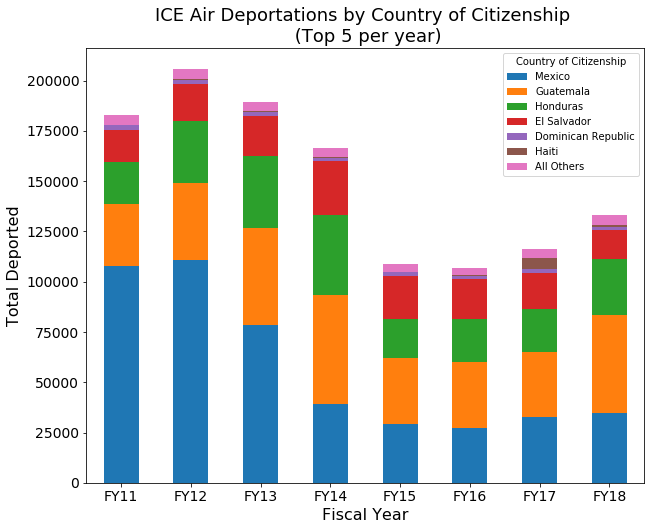

In [64]:
country_of_citizenship_trend(top_5_data,
                             title='ICE Air Deportations by Country of Citizenship \n (Top 5 per year)',
                             filename=f'top5_total_deportation_nationalities_per_year',
                             ylabel='Total Deported',
                             xlabel='Fiscal Year');

Here's the alternate plot showing all nationalities which break the top 5 in any year. A bit messier, but outliers are still clear (El Salvador in FY14, Haiti in FY17, India in FY18), steady trends possibly clearer (Ecuador, Dominican Republic).

In [46]:
in_top_5 = list()
for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    in_top_5.extend(list(temp_top_5['CountryOfCitizenship']))

In [47]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[temp['CountryOfCitizenship'].isin(list(set(in_top_5)))]
    if len(temp) > 5:
        all_others = temp[~temp['CountryOfCitizenship'].isin(list(set(in_top_5)))]
        all_other_count = sum(all_others['AlienMasterID'])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [48]:
# Table for this version of chart is much better
top_5_data

Country of Citizenship,Mexico,Guatemala,Honduras,El Salvador,Dominican Republic,Haiti,All Others
FY11,108021,30475,21183,15817,2343,228,4740
FY12,110870,38400,30815,18108,2281,547,4933
FY13,78650,47956,35759,20178,1849,452,4417
FY14,39279,54270,39827,26508,1748,338,4382
FY15,29461,32599,19613,21378,1552,369,3583
FY16,27082,32963,21311,20089,1556,267,3614
FY17,32967,32198,21241,17970,1696,5549,4610
FY18,34738,48765,27777,14516,1520,805,5168


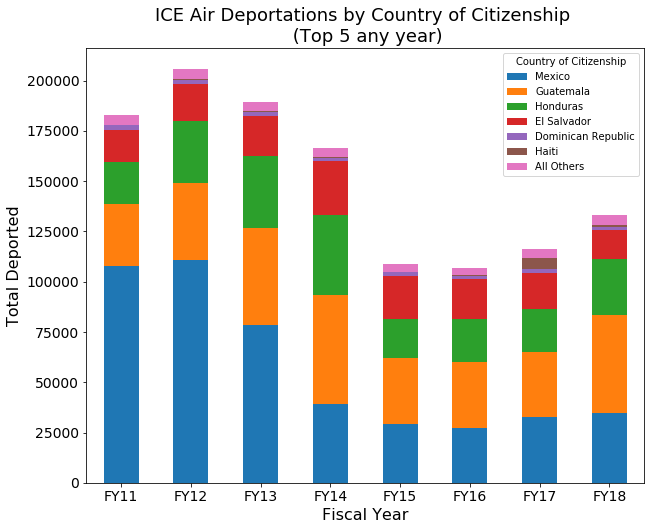

In [49]:
country_of_citizenship_trend(top_5_data,
                             title='ICE Air Deportations by Country of Citizenship \n (Top 5 any year)',
                             filename=f'top5_total_deportation_nationalities_any_year',
                             ylabel='Total Deported',
                             xlabel='Fiscal Year');

# Other global variables

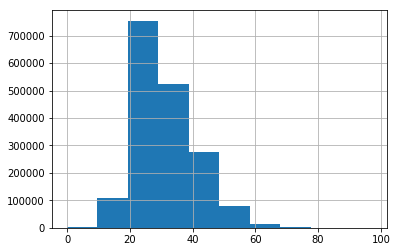

In [50]:
df['Age'].hist(bins=10)

In [51]:
df.groupby(['CountryOfCitizenship', 'R-T'])['Age'].mean()

CountryOfCitizenship            R-T
ALGERIA                         R      35.666668
                                T      36.555557
ARGENTINA                       R      43.214287
                                T      39.827587
ARMENIA                         T      33.634750
BANGLADESH                      R      33.685184
                                T      30.207924
BARBADOS                        R      42.500000
                                T      39.705883
BOLIVIA                         R      34.000000
                                T      35.030769
BOSNIA                          R      33.363636
                                T      31.839506
BRAZIL                          R      38.312500
                                T      33.467175
BRITISH VIRGIN ISLANDS          T      39.571430
BULGARIA                        R      31.000000
                                T      39.063492
CAMBODIA                        R      41.174999
                                T

In [52]:
df.groupby([pd.Grouper(freq='AS-OCT')])['Age'].mean()

MissionDate
2010-10-01    31.515244
2011-10-01    31.245144
2012-10-01    30.822685
2013-10-01    29.544395
2014-10-01    31.358904
2015-10-01    31.364090
2016-10-01    32.183548
2017-10-01    31.832045
2018-10-01    30.840059
Freq: AS-OCT, Name: Age, dtype: float32

In [53]:
df.groupby([pd.Grouper(freq='AS-OCT')])['Sex'].value_counts() / df.groupby([pd.Grouper(freq='AS-OCT')]).size() * 100

MissionDate  Sex
2010-10-01   M      94.507017
             F       5.489979
             U       0.002145
2011-10-01   M      95.185309
             F       4.801934
             U       0.012758
2012-10-01   M      93.870367
             F       6.118253
             U       0.011380
2013-10-01   M      86.746433
             F      13.236738
             U       0.016829
2014-10-01   M      89.261271
             F      10.731089
             U       0.006367
2015-10-01   M      90.129518
             F       9.870482
2016-10-01   M      90.432078
             F       9.561824
             U       0.006098
2017-10-01   M      92.114710
             F       7.883724
             U       0.001565
2018-10-01   M      92.012668
             F       7.987332
dtype: float64

# Different geographic subsets

In [54]:
df.columns

Index(['AlienMasterID', 'Status', 'Sex', 'Convictions', 'GangMember',
       'ClassLvl', 'Age', 'MissionNumber', 'PULOC', 'DropLoc',
       'StrikeFromList', 'ReasonStruck', 'R-T', 'Code', 'CountryOfCitizenship',
       'Juvenile', 'MissionWeek', 'MissionQuarter', 'MissionYear',
       'MissionMonth', 'Criminality', 'FamilyUnitFlag', 'UnaccompaniedFlag',
       'MissionID', 'air_AirportID', 'air_AirportName', 'air_City',
       'st_StateID', 'st_StateAbbr', 'AOR_AORID', 'AOR_AOR', 'AOR_AORName',
       'air_Country', 'air2_AirportID', 'air2_AirportName', 'air2_City',
       'st2_StateID', 'st2_StateAbbr', 'aor2_AORID', 'aor2_AOR',
       'aor2_AORName', 'air2_Country', 'NonCriminal', 'count'],
      dtype='object')

In [55]:
wa_pickup_df = df[df['st_StateAbbr'] == 'WA']

In [56]:
wa_dropoff_df = df[df['st2_StateAbbr'] == 'WA']

In [57]:
wa_pickup_df['PULOC'].value_counts()

KBFI    34466
KPAE      319
KYKM      108
KSEA        7
KALB        0
KCVG        0
KSAN        0
KSAT        0
KSLC        0
KTOL        0
KTWF        0
KBOS        0
KCOS        0
KSMF        0
KORD        0
KBOI        0
KCMH        0
KDFW        0
KDTW        0
MSLP        0
KTUS        0
KRNO        0
KONT        0
KEWR        0
KIAH        0
KATL        0
KBFL        0
KCSG        0
KDAL        0
KDEN        0
        ...  
MDSD        0
TIST        0
KSDM        0
KVCV        0
KCHS        0
KABQ        0
KMEM        0
KFTW        0
KPSM        0
KBED        0
MTPP        0
MKJP        0
KMWA        0
KJAX        0
MGGT        0
KTEB        0
EDDF        0
KBUF        0
SEGU        0
TJSJ        0
MHLM        0
KYIP        0
KPHX        0
KNJK        0
KAUS        0
KCRP        0
KGRK        0
KGYY        0
TJBQ        0
KAEX        0
Name: PULOC, Length: 83, dtype: int64

In [58]:
wa_pickup_df[wa_pickup_df['PULOC'] == 'KYKM']['CountryOfCitizenship'].value_counts().head()

HAITI         108
GUADELOUPE      0
MOZAMBIQUE      0
SYRIA           0
SWEDEN          0
Name: CountryOfCitizenship, dtype: int64

In [59]:
wa_all = pd.concat([wa_pickup_df, wa_dropoff_df])

In [60]:
wa_pickup_df.groupby([pd.Grouper(freq='AS-OCT'), 'air_AirportName', 'CountryOfCitizenship'])['AlienMasterID'].nunique()

MissionDate  air_AirportName                                 CountryOfCitizenship
2010-10-01   Boeing Field King County International Airport  ARGENTINA                  1
                                                             BULGARIA                   1
                                                             CAMBODIA                   2
                                                             CHINA                      7
                                                             COLOMBIA                   6
                                                             DOMINICAN REPUBLIC         3
                                                             ECUADOR                   28
                                                             EL SALVADOR              183
                                                             GUATEMALA                381
                                                             HONDURAS                 178
                  